<a href="https://colab.research.google.com/github/DishaPanigrahy/Upskill_Project/blob/main/Two_data_preprocessing_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def iou_calc(true_bbox , selectivesarch_bbox):
    '''
    true_bbox           : true bounding box
    selectivesarch_bbox : bounding box output from selective search algorithm

    '''

    true_xmin, true_ymin, true_width, true_height  = true_bbox
    bb_xmin, bb_ymin,  bb_width, bb_height = selectivesarch_bbox

    true_xmax = true_xmin + true_width
    true_ymax = true_ymin + true_height
    bb_xmax = bb_xmin + bb_width
    bb_ymax = bb_ymin + bb_height

    #calculating area
    true_area = true_width * true_height
    bb_area   = bb_width * bb_height

    #calculating itersection cordinates
    inter_xmin = max(true_xmin , bb_xmin)
    inter_ymin = max(true_ymin , bb_ymin)
    inter_xmax = min(true_xmax , bb_xmax)
    inter_ymax = min(true_ymax , bb_ymax)

    if inter_xmax <= inter_xmin or inter_ymax <= inter_ymin:
        iou = 0


    else:
        inter_area = (inter_xmax - inter_xmin) * (inter_ymax - inter_ymin)


        iou = inter_area / (true_area + bb_area - inter_area)

    assert iou<=1
    assert iou>=0

    return iou




In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


def iou_filter(image_path,true_bb,thresh=0.5):

    '''
    arguments:
    1. image_path: path of images
    2. true_bb: true labeled dataframe of image columns = ['filename','width','height','class','xmin','ymin','xmax','ymax']
    3. thresh: threshhold value for intersection over union(iou), by default 0.5

    returns:
    filtered_selective_search: rigion which iou is higher than threshhold value of given image and class of that object
    negative_example         : return region which iou is less than thresh value and not conflict with other object region

    '''

    img_name = image_path.split('/')[-1]

    img_bb = true_bb[true_bb['filename']==img_name].reset_index(drop=True)

    img = cv2.imread(image_path)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()

    ss_bb = rects[:2000]

    filtered_selective_search = []

    negative_examples = []

    maybe_neagative = []

    # loop to compute iou for all label of perticular image
    for label in range(len(img_bb)):


        #unpacking cordinates
        true_xmin, true_ymin, true_width, true_height  = img_bb.loc[label,'xmin'], img_bb.loc[label,'ymin'], img_bb.loc[label,'xmax']-img_bb.loc[label,'xmin'], img_bb.loc[label,'ymax']-img_bb.loc[label,'ymin']
        class_of_label = img_bb.loc[label,'class']

        #loop to compute iou for all selective search of perticular label
        for j,rect in enumerate(ss_bb):
            calculating_iou_for_selectivesearch = iou_calc([true_xmin, true_ymin, true_width, true_height],rect)

            if calculating_iou_for_selectivesearch > thresh:
                filtered_selective_search.append([list(rect),class_of_label])

            elif calculating_iou_for_selectivesearch <0.2:
                maybe_neagative.append(list(rect))

    #removing duplicate entries

    def Remove(duplicate):
        final_list = []
        for num in duplicate:
            if num not in final_list:
                final_list.append(num)
        return final_list

    maybe_neagative = Remove(maybe_neagative)
    filtered_selective_search = Remove(filtered_selective_search)


    #this is will use for background class for CNN which has iou less than 0.2, In paper it's 0.3 but in that also written that it's depends on dataset.

    only_labels_of_filtered_selective_search = [x[0] for x in filtered_selective_search]

    for lab in maybe_neagative:
        condition = []
        for true_lab in only_labels_of_filtered_selective_search:

            iou_for_negative_ex = iou_calc(true_lab,lab)

            condition.append(True) if iou_for_negative_ex <= 0.2  else condition.append(False)

        if False not in condition:
            negative_examples.append(lab)

    negative_examples = Remove(negative_examples)
    random_background_images_index = np.random.randint(low=0, high=len(negative_examples), size=2*len(only_labels_of_filtered_selective_search))
    random_background_images = [negative_examples[x] for x in random_background_images_index]


    return filtered_selective_search , Remove(random_background_images)

In [ ]:
path = '/content/drive/MyDrive/Project5_Ag_Crop_and_weed_detection/agri_data/images/'

# Preprocessing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project5_Ag_Crop_and_weed_detection/agri_data/agri_label.csv')

In [ ]:
df.head()

filename  width  height class  xmin  ymin  xmax  ymax
0  agri_0_6581.jpeg    512     512  weed   117   132   399   393
1  agri_0_6604.jpeg    512     512  weed    68   134   412   392
2  agri_0_6605.jpeg    512     512  crop     0    69   404   511
3  agri_0_6605.jpeg    512     512  crop   259     0   512   264
4  agri_0_6642.jpeg    512     512  crop   208   182   371   358

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2072 non-null   object
 1   width     2072 non-null   int64 
 2   height    2072 non-null   int64 
 3   class     2072 non-null   object
 4   xmin      2072 non-null   int64 
 5   ymin      2072 non-null   int64 
 6   xmax      2072 non-null   int64 
 7   ymax      2072 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 129.6+ KB


now checking all labeled images are available in the folder or not

In [ ]:
folder_images = os.listdir(path)

In [ ]:
len(images)

1300

In [ ]:
train_images = folder_images[:1000]

In [ ]:
test_images = folder_images[1000:]

In [ ]:
j=0
for i in tqdm(list(df['filename'].unique())):
    if i in folder_images:
        j+=1
print(j)

100%|██████████| 1300/1300 [00:00<00:00, 49143.73it/s]

1300


# Visualizing the Dataset

16it [00:03,  4.88it/s]


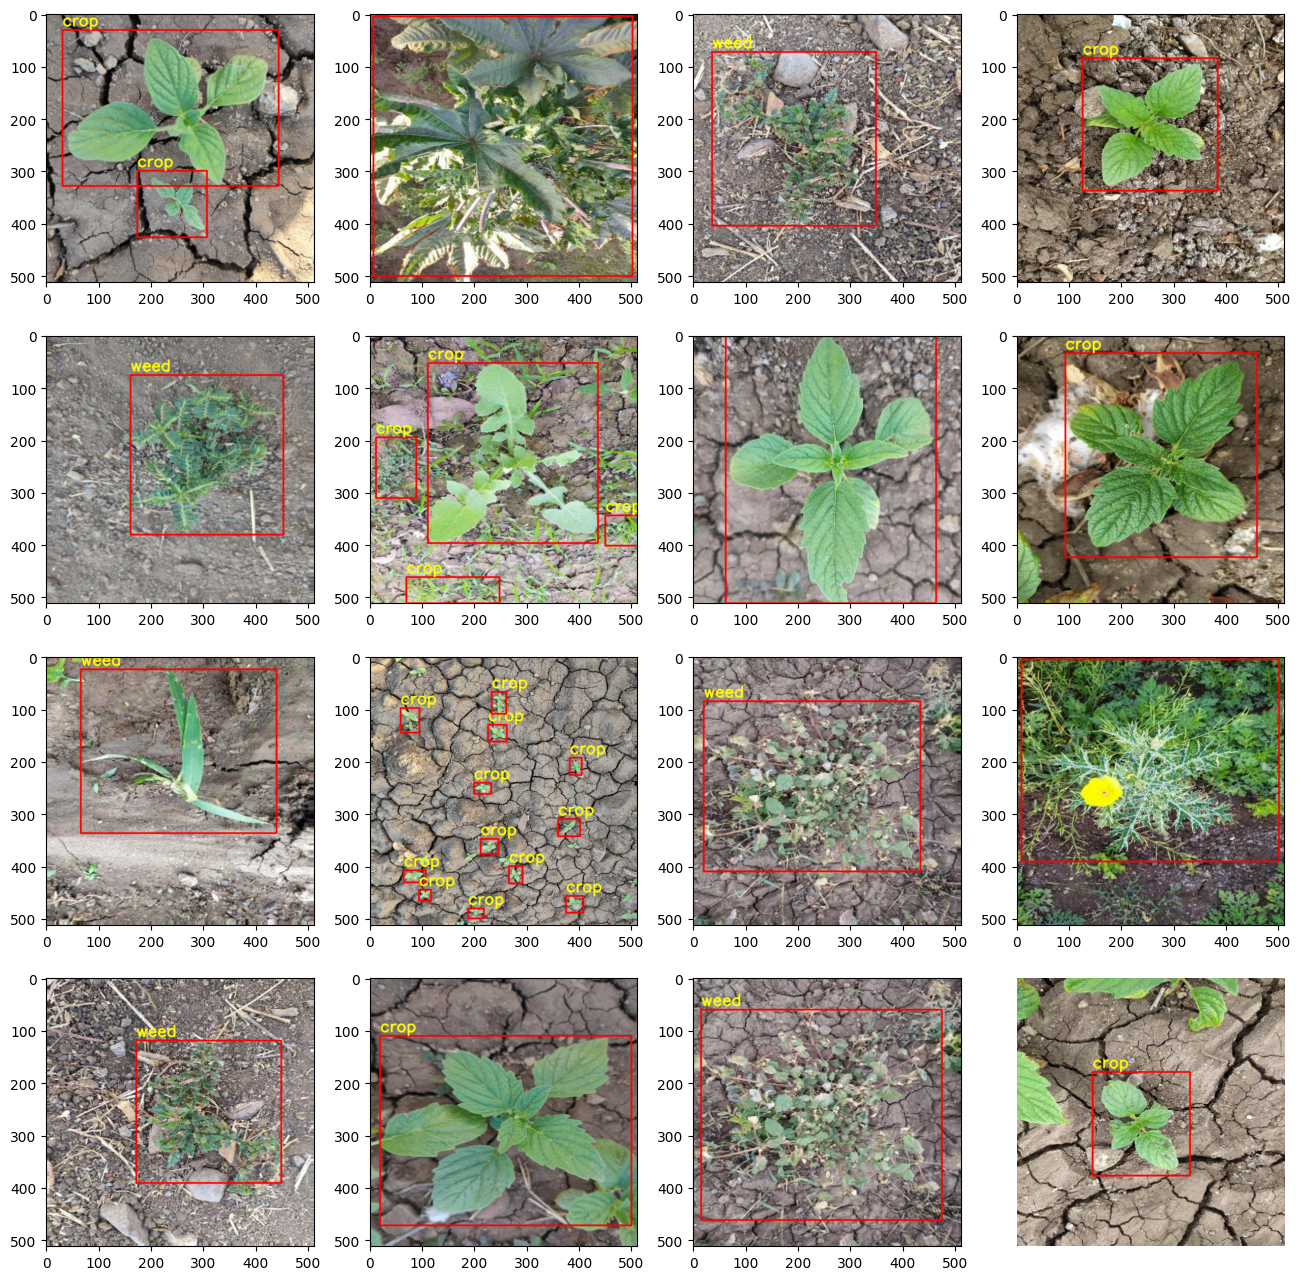

In [ ]:
_ , axes = plt.subplots(4,4,figsize=(16,16))
for i,ax in tqdm(zip(range(16),axes.flat)):
    temp_df = df[df['filename']==folder_images[i]].reset_index(drop=True)
    temp_img = cv2.imread(path+folder_images[i])
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
    for j in range(len(temp_df)):
        rect = cv2.rectangle(temp_img,(temp_df.loc[j,'xmin'],temp_df.loc[j,'ymin']),(temp_df.loc[j,'xmax'],temp_df.loc[j,'ymax']),(255,0,0),2,cv2.LINE_AA)
        rect_text = cv2.putText(rect,temp_df.loc[j,'class'],(temp_df.loc[j,'xmin'],temp_df.loc[j,'ymin']-8), cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,0), 2, cv2.LINE_AA)
    ax.imshow(rect_text)
    plt.axis('off')


# Selective search

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
img = cv2.imread(path+folder_images[45])
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()

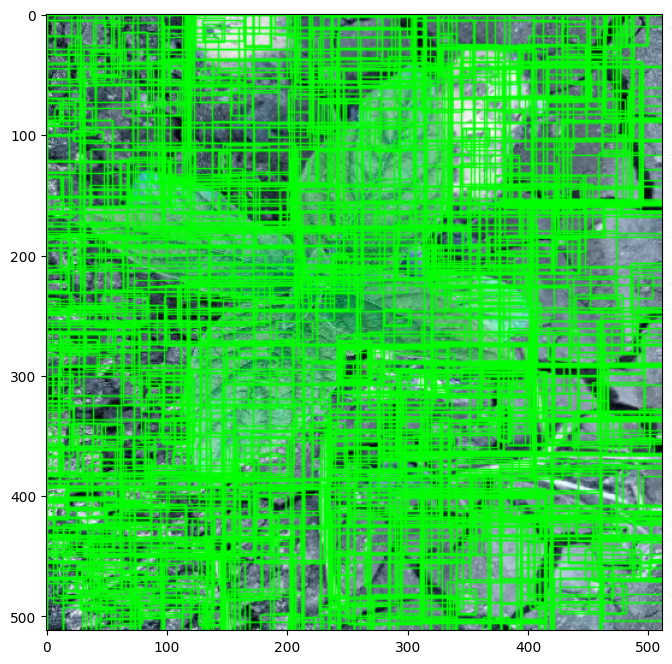

In [ ]:
sel_rects = rects[:1200]
imOut = img.copy()
for i, rect in (enumerate(sel_rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure(figsize=(8,8))
plt.imshow(imOut)

# Define some function
Now we use our defined function for getting region proposal from images. In this function we just have to add image path and dataframe which contain true label of that image in ['filename','width','height','class','xmin','ymin','xmax','ymax'] this format.

# Check for one image

In [ ]:
ss,neg =iou_filter(path+folder_images[1280],df,thresh=0.5)

Now visualize only region which have IoU greater than 0.5

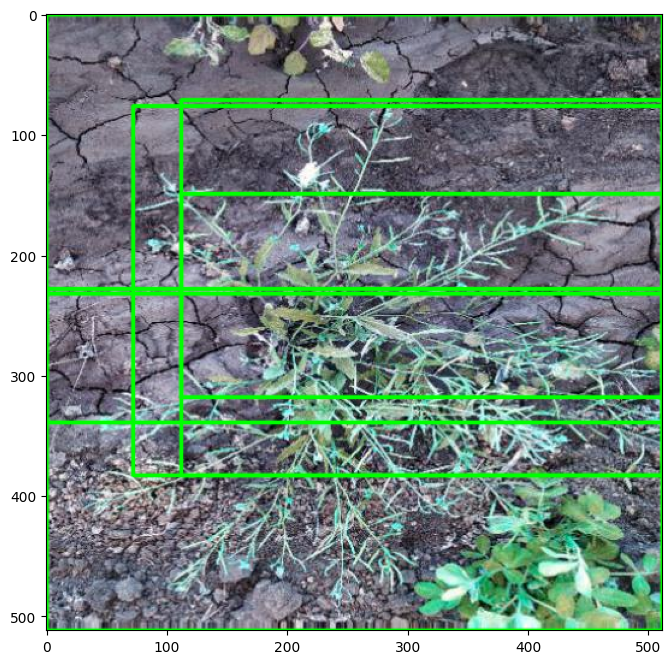

In [ ]:
img = cv2.imread(path+folder_images[1280])
for i, rect in (enumerate(ss)):
    x, y, w, h = rect[0]
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2, cv2.LINE_AA)

plt.figure(figsize=(12,8))
plt.imshow(img)

In [ ]:
len(ss)

6

In [ ]:
len(neg)

12

Regions which has iou < 0.2 Which will use for background class training in CNN

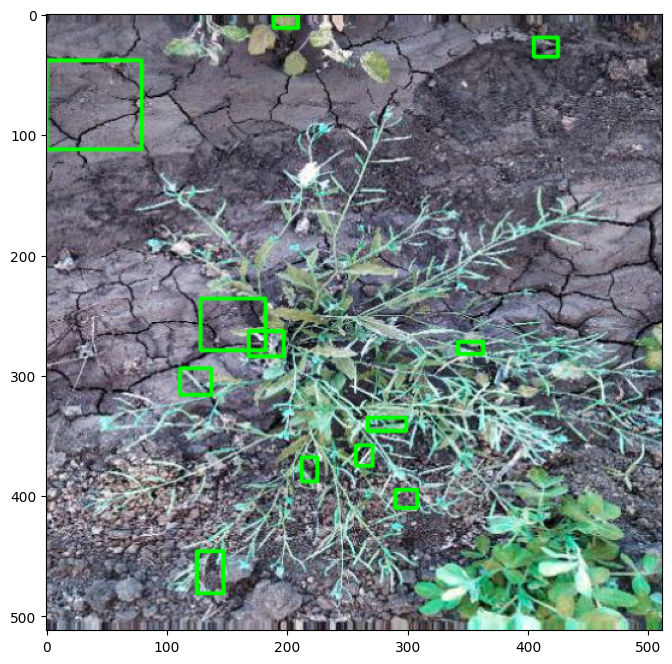

In [ ]:
img = cv2.imread(path+folder_images[1280])
for i, rect in (enumerate(neg)):
    x, y, w, h = rect

    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2, cv2.LINE_AA)


plt.figure(figsize=(12,8))
plt.imshow(img)

# Saving all region proposal of all images

In [ ]:
train_data = {}
test_data  = {}

This will take arround 1.5 hour to process so if you don't want to proccess it all ready in DATA directory.

In [ ]:
for i,img in tqdm(enumerate(train_images)):
    ss,neg =iou_filter(path + img , df , thresh=0.5)
    train_data[img] = {'region_proposal':ss,'negative_example':neg}

0it [00:00, ?it/s]


AttributeError: ignored

In [ ]:
for i,img in tqdm(enumerate(test_images)):
    ss,neg =iou_filter(path + img , df , thresh=0.5)
    test_data[img] = {'region_proposal':ss,'negative_example':neg}

In [ ]:
#converting numpy instantant into python datatype
import json
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [ ]:
with open('train.json','w+') as output_file:
    json.dump(train_data,output_file,cls=MyEncoder)

In [ ]:
with open('test.json','w+') as output_file:
    json.dump(test_data,output_file,cls=MyEncoder)

checking our conversion is right or wrong

In [ ]:
with open('train.json') as train:
    train_json = json.load(train)

In [ ]:
with open('test.json') as test:
    test_json = json.load(test)

In [ ]:
train_json == train_data

True

In [ ]:
test_json == test_data

True